<a href="https://colab.research.google.com/github/LeyloJohnny/Computational-Neuroscience/blob/main/Cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cluster analysis

### Access and understand data

Get data files:

In [1]:
#get data from google drive
!gdown --id 1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
#unzip data
!unzip 'NewData.zip'

Downloading...
From: https://drive.google.com/uc?id=1qblO7uQCJ6KKclqS-rhvXfQ7ccWcmxaA
To: /content/NewData.zip
127MB [00:00, 191MB/s]
Archive:  NewData.zip
replace Cluster.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
#show all data files
!ls
# BN : Balanced Network
# IAF: clustered wo SFA (Spike-frequency adaptation)
# GIF: clustered with SFA

BN.pkl	     NewData.zip  SFA.pkl
Cluster.pkl  sample_data  spike_count_matrix_tr_10000_tw_1.npy


Get a list of data for all three models:

In [3]:
import pickle

#create a list of model name strings
models = ['BN.pkl', "SFA.pkl", "Cluster.pkl"]

#create a list of model names
model_names = ["Balanced Network", "Clustered with SFA", "Clustered wo SFA"]

#create lists to store model data
models_x = []
models_y = []

#for all models
for i in range(len(models)):

  #open pickle file
  with open(models[i], 'rb') as f:
    #get x (actual data: time * neuron id)
    x = pickle.load(f)
    #get y (information on data, such as inhibitory/excitatory neurons, clusters, etc.)
    y = pickle.load(f)
    #add x and y to the models lists
    models_x.append(x)
    models_y.append(y)

What does the data look like?

In [4]:
#show y
models_y[1]

{'I_th_E': 2.13,
 'I_th_I': 1.24,
 'N_E': 4000,
 'N_I': 1000,
 'Q': 50,
 'delta_I_xE': 0.0,
 'delta_I_xI': 0.0,
 'dt': 0.001,
 'jplus': array([[18.  , 13.75],
        [13.75, 13.75]]),
 'n_jobs': 26,
 'neuron_type': 'gif_psc_exp',
 'q_stc': [0.08333333333333333],
 'record_from': 1,
 'record_voltage': False,
 'simtime': 300000,
 'tau_stc': [180.0],
 'warmup': 250}

###Extract certain time range

In [110]:
import numpy as np
import pandas as pd

time_range_models = []

time_range = 30000

for model in range(len(models)):
  #set condition: returns True for time <= 5 s
  condition = [True if i <= time_range else False for i in models_x[model][0]]

  #extract new x and y values for array based on condition
  new_x = np.extract(condition, models_x[model][0])
  new_y = np.extract(condition, models_x[model][1])

  new = [new_x, new_y]

  #time_range_x.append(new_x)
  #time_range_y.append(new_y)

  time_range_models.append(new)

### Create raster plots from data for one cluster

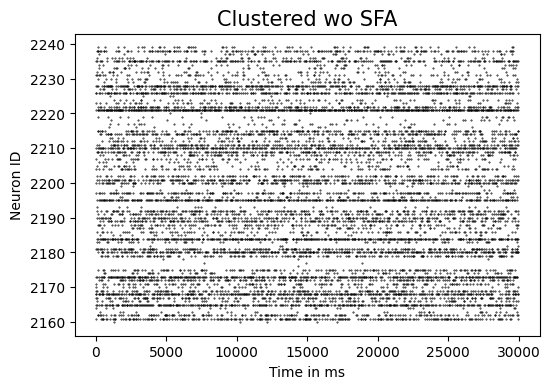

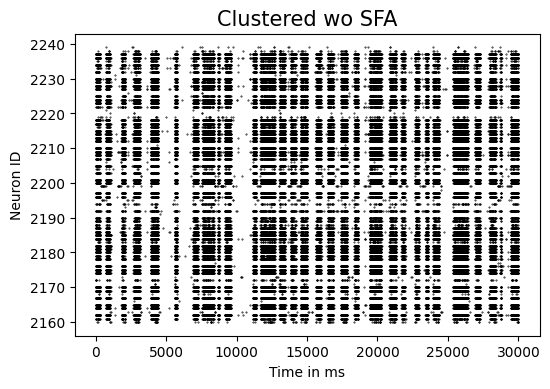

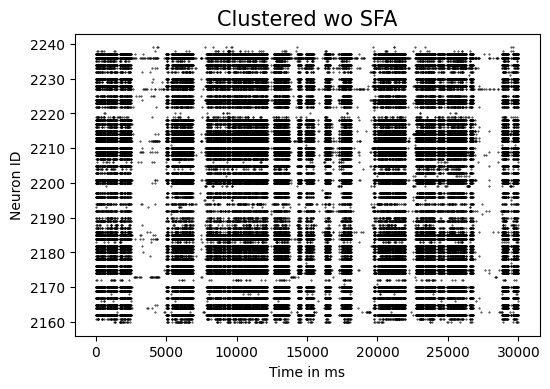

In [112]:
import matplotlib.pyplot as plt

one_cluster = []

neuron_ID = 2159

for model in range(len(models)):

  condition = [True if i > neuron_ID and i <= neuron_ID+80 else False for i in time_range_models[model][1]]

  #extract new x and y values for array based on condition
  new_x = np.extract(condition, time_range_models[model][0])
  new_y = np.extract(condition, time_range_models[model][1])

  #create figure
  figure = plt.figure(dpi=100)
  #create subplot
  ax = figure.add_subplot(1,1,1)
  #plot both dimensions of x (time, neuron id)
  plt.plot(new_x,new_y,'.k',markersize = 0.8) 

  #label the plot
  ax.set_xlabel('Time in ms', fontsize = 10)
  ax.set_ylabel('Neuron ID', fontsize = 10)
  ax.set_title(model_names[i], fontsize = 15)

  new = [new_x, new_y]

  one_cluster.append(new)

### Create spike count matrix

In [113]:
import numpy as np

#define a time window (in milliseconds)
window = 50

file_name = "spike_count_matrix_tr_" + str(time_range) + "_tw_" + str(window)

#calculate number of intervals based on recorded time span / time window
intervals = int(np.max(time_range_models[i][0]+ 1)/window)

#define which neurons to focus on 
neurons = 80 

#how many intervals do we have?
print("We have " + str(intervals) + " intervals, each " + str(window) + "ms long. \n")

spike_count_matrix = np.zeros((len(models), intervals, neurons))

#for every model
for i in range(len(models)):
  #get the data of the current model
  current_model_x = np.array(one_cluster[i])

  #create a zeros array with size time * neurons (5000*4000)
  spike_counts = np.zeros((intervals, neurons))

  #for every interval
  for j in range(intervals):

    #get the indices of time points within the current interval
    interval_time_points = np.where(np.logical_and(window*j <= current_model_x[0], current_model_x[0] < window*(j+1)))

    #get data indexed by current interval
    interval_data = current_model_x[1][interval_time_points]
    
    #for every neuron
    for k in range(neurons):

        #get the indices of the current neuron within the defined time interval
        current_neuron = np.where(interval_data == neuron_ID+k)

        #get the number of spikes based on the amount of neuron indices within the defined time interval
        spikes = current_neuron[0].shape[0]

        #add spikes number to spike count matrix
        spike_counts[j, k] = spikes
  
  #add spike count matrix for every model
  spike_count_matrix[i] = spike_counts

np.save(file_name, spike_count_matrix)

#print data
print("The spike count matrix has the shape: " + str(spike_count_matrix.shape) + " representing " + 
      str(spike_count_matrix.shape[0]) + " models, " + str(spike_count_matrix.shape[1]) + " intervals, and " + str(spike_count_matrix.shape[2]) + " neurons. \n")
print("Spike count matrix: \n")
print(spike_count_matrix)

We have 600 intervals, each 50ms long. 

The spike count matrix has the shape: (3, 600, 80) representing 3 models, 600 intervals, and 80 neurons. 

Spike count matrix: 

[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 1. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 3. ... 8. 6. 0.]
  [0. 0. 2. ... 7. 6. 0.]
  [0. 2. 1. ... 7. 8. 0.]
  ...
  [0. 0. 4. ... 8. 7. 0.]
  [0. 2. 0. ... 7. 5. 0.]
  [0. 3. 3. ... 8. 7. 0.]]

 [[0. 0. 1. ... 7. 6. 0.]
  [0. 0. 0. ... 6. 4. 0.]
  [0. 0. 2. ... 7. 5. 1.]
  ...
  [0. 1. 1. ... 6. 5. 0.]
  [0. 1. 1. ... 7. 5. 0.]
  [0. 1. 0. ... 5. 5. 0.]]]


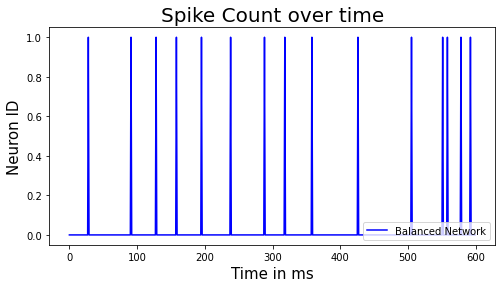

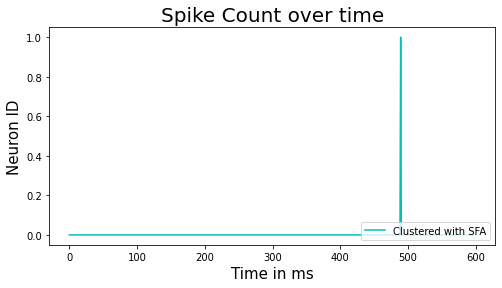

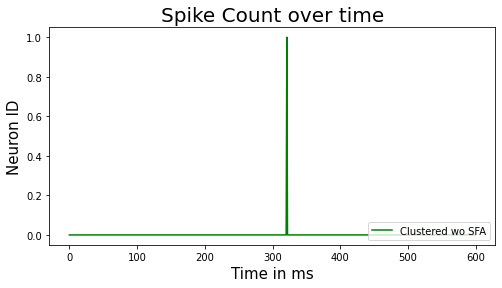

In [120]:
neuron = 39

for model in range(len(models)):

  one_neuron = []

  for timepoint in range(len(spike_count_matrix[model][:])):
    one_neuron.append(spike_count_matrix[model][timepoint][neuron])

  #define figure fig with a certain size
  fig = plt.figure(figsize = (8,4))
  #define axis, two axis, index position = 1
  ax = fig.add_subplot(1,1,1) 
  #set labels and title of figure
  ax.set_xlabel('Time in ms', fontsize = 15)
  ax.set_ylabel('Neuron ID', fontsize = 15)
  ax.set_title('Spike Count over time', fontsize = 20)

  #define colors for different models
  colors = ['b', 'c', 'g']

  #for neuron in range(len(spike_count_matrix[model][0])):

  #plot the data
  ax.plot(range(len(one_neuron)), one_neuron, color = colors[model], label = model_names[model])
  #fill area of positive and negative errors
  plt.legend(loc = "lower right")

In [115]:
all_model_neurons = []

for model in range(len(models)):

  all_neurons = np.zeros((len(spike_count_matrix[model][0]), len(spike_count_matrix[model][:])))
  
  for neuron in range(len(spike_count_matrix[model][0])):

    current_neuron = np.zeros(len(spike_count_matrix[model][:]))

    for timepoint in range(len(spike_count_matrix[model][:])):
      #current_neuron[timepoint] = spike_count_matrix[model][timepoint][neuron]

      all_neurons[neuron, timepoint] = spike_count_matrix[model][timepoint][neuron]
  
  all_model_neurons.append(all_neurons)

In [116]:
all_model_variance = []

for model in range(len(models)):

  current_variance = []

  for neuron in range(len(all_model_neurons[0])):

    current = np.var(all_model_neurons[model][neuron][:])
    current_variance.append(current)
  
  all_model_variance.append(current_variance)

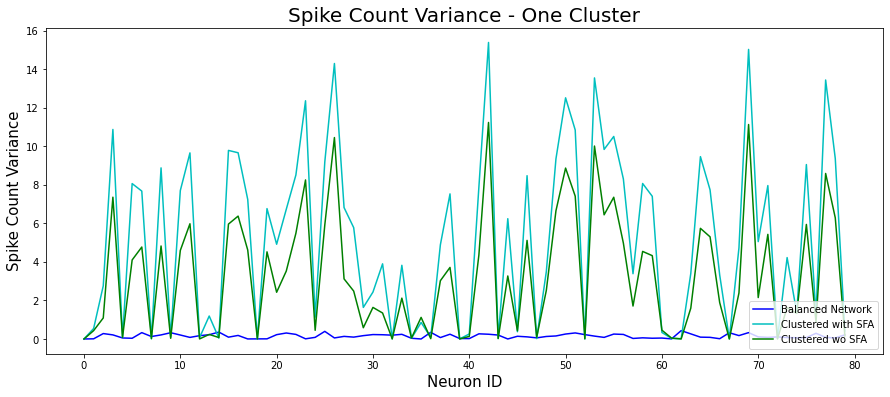

In [122]:
#define figure fig with a certain size
fig = plt.figure(figsize = (15,6))
#define axis, two axis, index position = 1
ax = fig.add_subplot(1,1,1) 
#set labels and title of figure
ax.set_xlabel('Neuron ID', fontsize = 15)
ax.set_ylabel('Spike Count Variance', fontsize = 15)
ax.set_title('Spike Count Variance - One Cluster', fontsize = 20)

#define colors for different models
colors = ['b', 'c', 'g']

#for tuple of target and color: (target, color)
for model in range(len(models)):

  #plot the data
  ax.plot(range(len(all_model_variance[model])), all_model_variance[model], color = colors[model], label = model_names[model])

  plt.legend(loc = "lower right")

